# Physics-Informed Neural Network (PINN) for 2D Incompressible Navier–Stokes Equations

This notebook implements a Physics-Informed Neural Network (PINN) to solve the **2D incompressible Navier–Stokes equations** using the **Taylor–Green vortex**.

##  Problem Statement

We aim to learn the time evolution of the velocity field (u(x, y, t), v(x, y, t)) in a 2D periodic domain governed by the incompressible Navier–Stokes equations:

$$
\begin{aligned}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} &= -\frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \\
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} &= -\frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) \\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} &= 0
\end{aligned}
$$

where $(\nu)$ is the kinematic viscosity (set to 0.01 in this case).

##  Exact Solution (Taylor–Green Vortex)

We use the known analytical solution as a reference to train and evaluate the PINN:

$$
\begin{aligned}
u(x, y, t) &= \sin(x) \cos(y) \, e^{-2\nu t} \\
v(x, y, t) &= -\cos(x) \sin(y) \, e^{-2\nu t} \\
p(x, y, t) &= -\frac{1}{4} \left( \cos(2x) + \cos(2y) \right) e^{-4\nu t}
\end{aligned}
$$

##  Domain

The problem is defined on the spatial domain:
$$
(x, y) \in [0, 2\pi] \times [0, 2\pi], \quad t \in [0, 1]
$$

##  Initial Conditions

At \(t = 0\), the exact initial conditions are:

$$
\begin{aligned}
u(x, y, t) &= \sin(x) \cos(y)\\
v(x, y, t) &= -\cos(x) \sin(y)\\
p(x, y, t) &= -\frac{1}{4} \left( \cos(2x) + \cos(2y) \right)
\end{aligned}
$$

These are enforced in the PINN as supervised conditions at \(t=0\).

##  Boundary Conditions

The problem assumes **periodic boundary conditions** in both \(x\) and \(y\) directions for all times:

$$
\begin{aligned}
u(0, y, t) = u(2\pi, y, t), &\quad u(x, 0, t) = u(x, 2\pi, t) \\
v(0, y, t) = v(2\pi, y, t), &\quad v(x, 0, t) = v(x, 2\pi, t)
\end{aligned}
$$


In [ ]:
# importing all required modules

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# picking random data points to compute various types of losses

pi = np.pi
N = 1000

# for physics loss
x_p = tf.random.uniform((N,1),minval=0.0,maxval=2*pi,dtype=tf.float32)
y_p = tf.random.uniform((N,1),minval=0.0,maxval=2*pi,dtype=tf.float32)
t_p = tf.random.uniform((N,1),minval=0.0,maxval=1.0,dtype=tf.float32)

# for boundary loss
x_b = tf.random.uniform((N,1),minval=0.0,maxval=2*pi,dtype=tf.float32)
y_b = tf.random.uniform((N,1),minval=0.0,maxval=2*pi,dtype=tf.float32)
t_b = tf.random.uniform((N,1),minval=0.0,maxval=2*pi,dtype=tf.float32)
x0yt_b = tf.concat([tf.zeros_like(x_b),y_b,t_b],axis=1)
x2piyt_b = tf.concat([tf.ones_like(x_b)*2*pi,y_b,t_b],axis=1)
xy0t_b = tf.concat([x_b,tf.zeros_like(y_b),t_b],axis=1)
xy2piyt_b = tf.concat([x_b,tf.ones_like(y_b)*2*pi,t_b],axis=1)
xyt_bl = tf.concat([x0yt_b,xy0t_b],axis=0)
xyt_br = tf.concat([x2piyt_b,xy2piyt_b],axis=0)

# for initial loss
x_i = tf.random.uniform((N,1),minval=0.0,maxval=2*pi,dtype=tf.float32)
y_i = tf.random.uniform((N,1),minval=0.0,maxval=2*pi,dtype=tf.float32)
t_i = tf.zeros_like(x_i)
xyt_i = tf.concat([x_i,y_i,t_i],axis=1)
u_i = tf.sin(x_i)*tf.cos(y_i)
v_i = -tf.cos(x_i)*tf.sin(y_i)
p_i = -0.25*(tf.cos(2*x_i) + tf.cos(2*y_i))
uvp_i = tf.concat([u_i,v_i,p_i],axis=1)

# mesh grid for visualizing
N_p = 100
x = np.linspace(0, 2 * np.pi, N_p)
y = np.linspace(0, 2 * np.pi, N_p)
X, Y = np.meshgrid(x, y)
T = np.full_like(X, 0.5)

xyt = np.stack([X.flatten(), Y.flatten(), T.flatten()], axis=1).astype(np.float32)
xyt_tensor = tf.convert_to_tensor(xyt)

In [ ]:
mu = 0.01

# exact solutions for comparision and validation
def u_exact(x,y,t):
    return tf.sin(x)*tf.cos(y)*np.exp(-2*mu*t)
def v_exact(x,y,t):
    return -tf.cos(x)*tf.sin(y)*np.exp(-2*mu*t)
def p_exact(x,y,t):
    return -0.25*(tf.cos(2*x) + tf.cos(2*y))*np.exp(-4*mu*t)

# defining the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(75,activation='tanh'),
    tf.keras.layers.Dense(75,activation='tanh'),
    tf.keras.layers.Dense(75,activation='tanh'),
    tf.keras.layers.Dense(75,activation='tanh'),
    tf.keras.layers.Dense(3)
])

Epoch 0, Loss: 1.3062344789505005


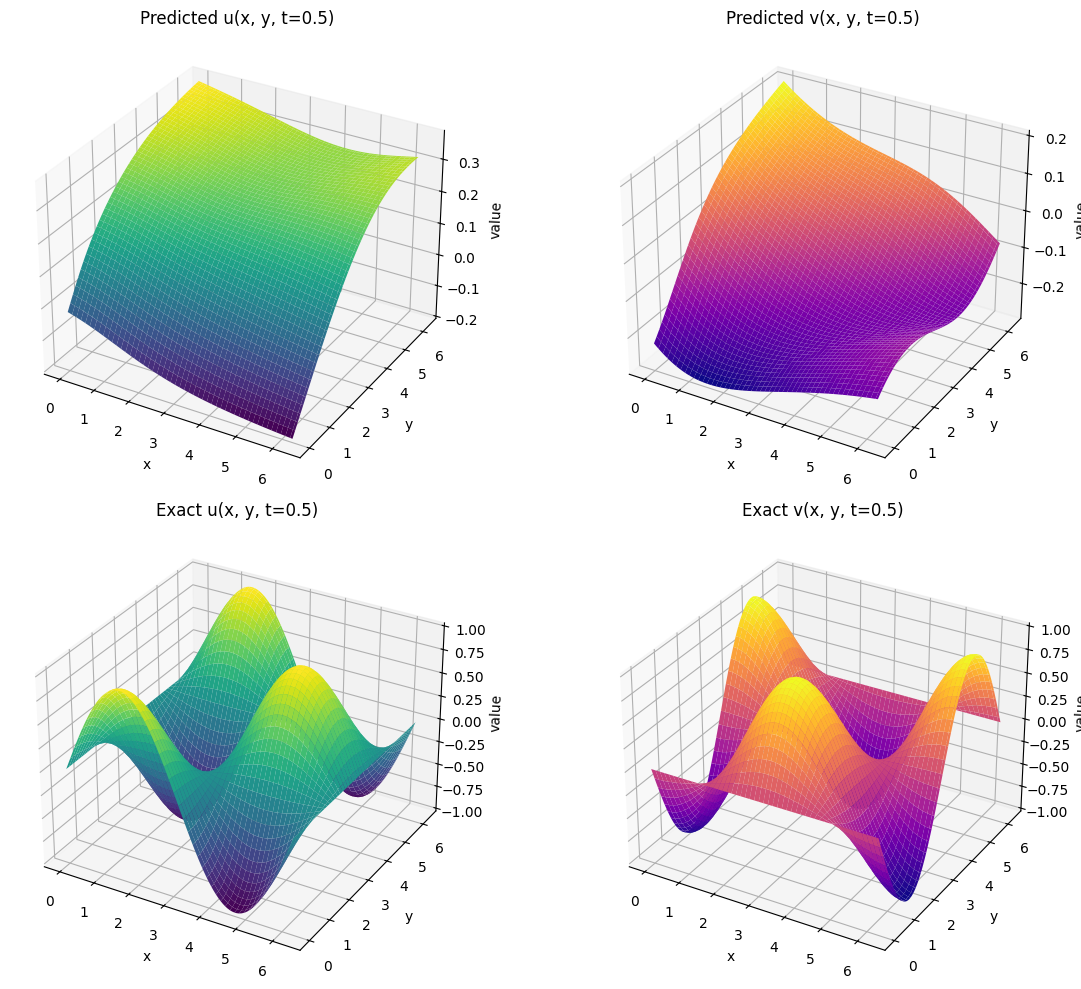

Epoch 5000, Loss: 0.0023175047244876623


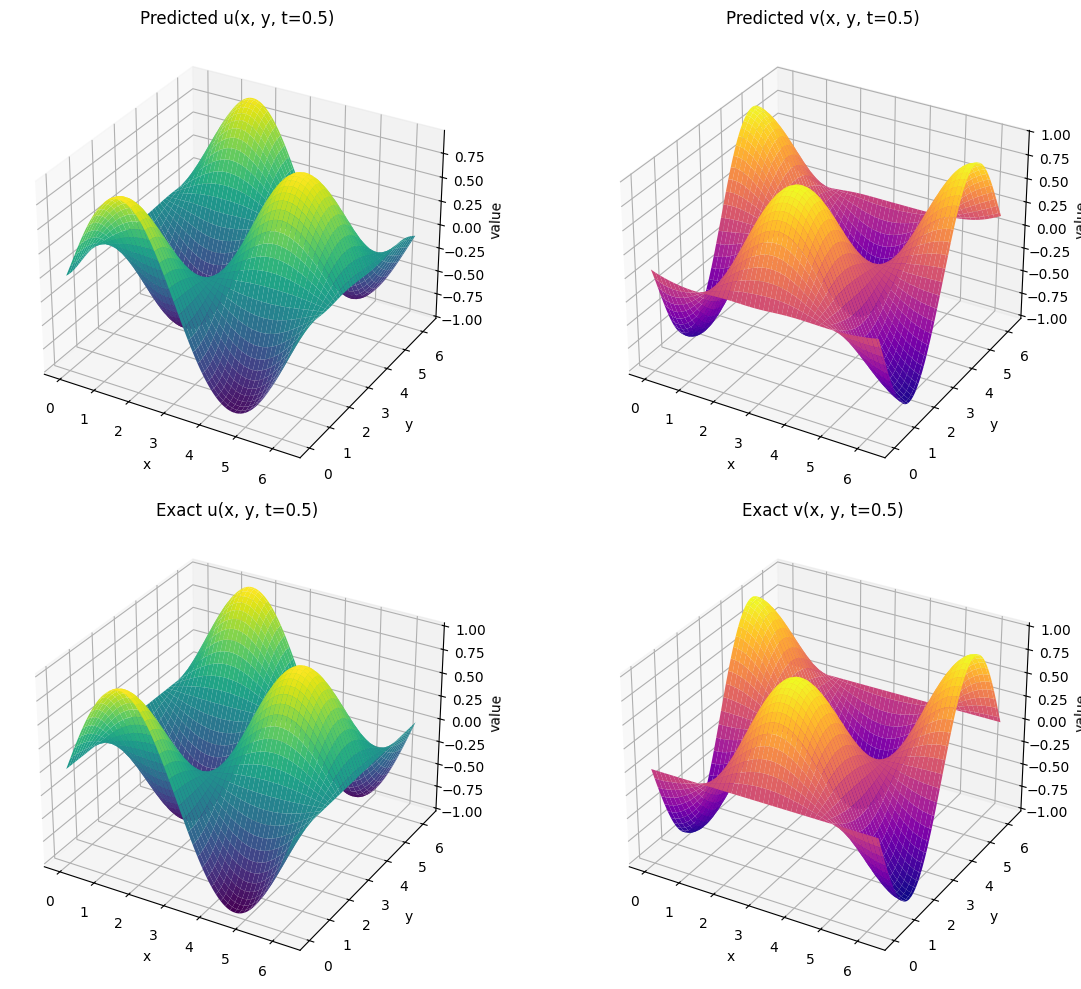

Epoch 10000, Loss: 0.0014930361649021506


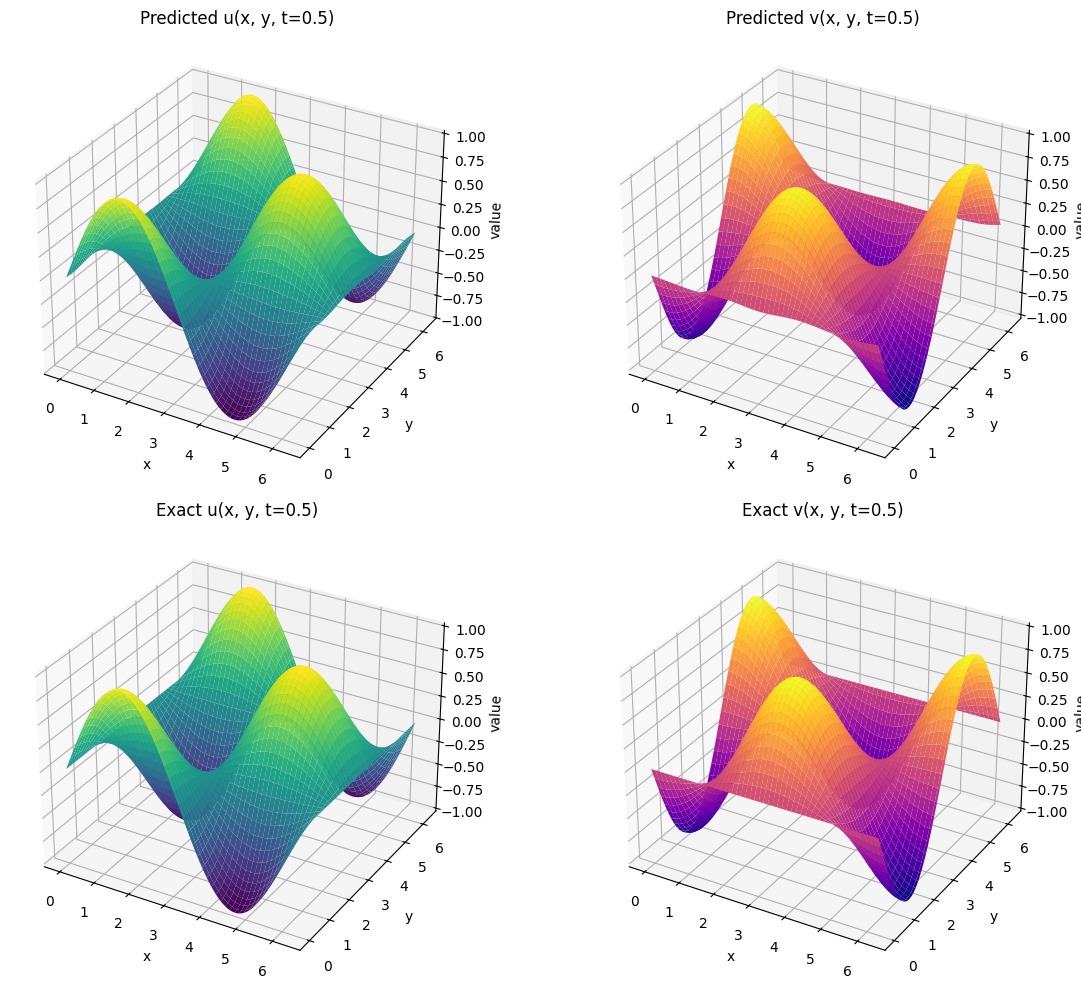

Epoch 15000, Loss: 0.0011681935284286737


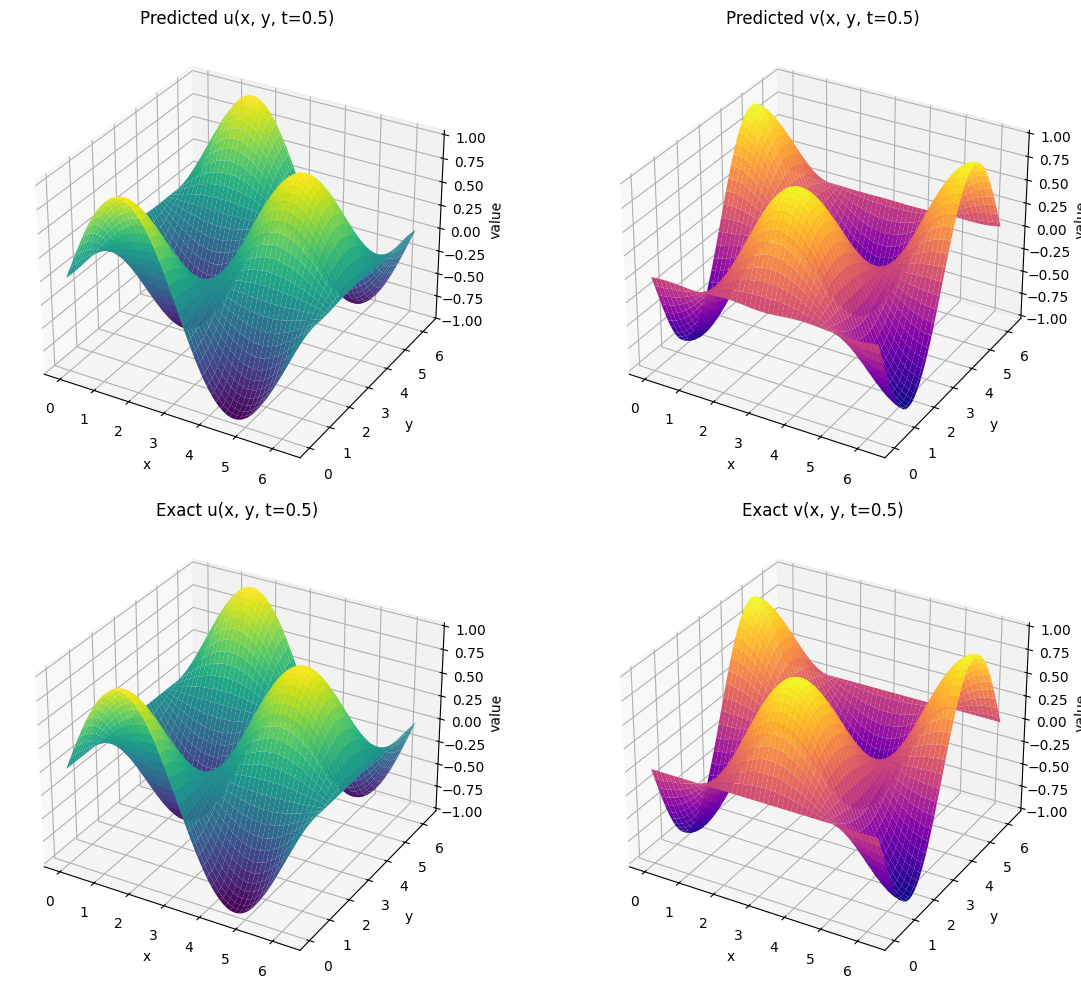

Epoch 20000, Loss: 0.0014527721796184778


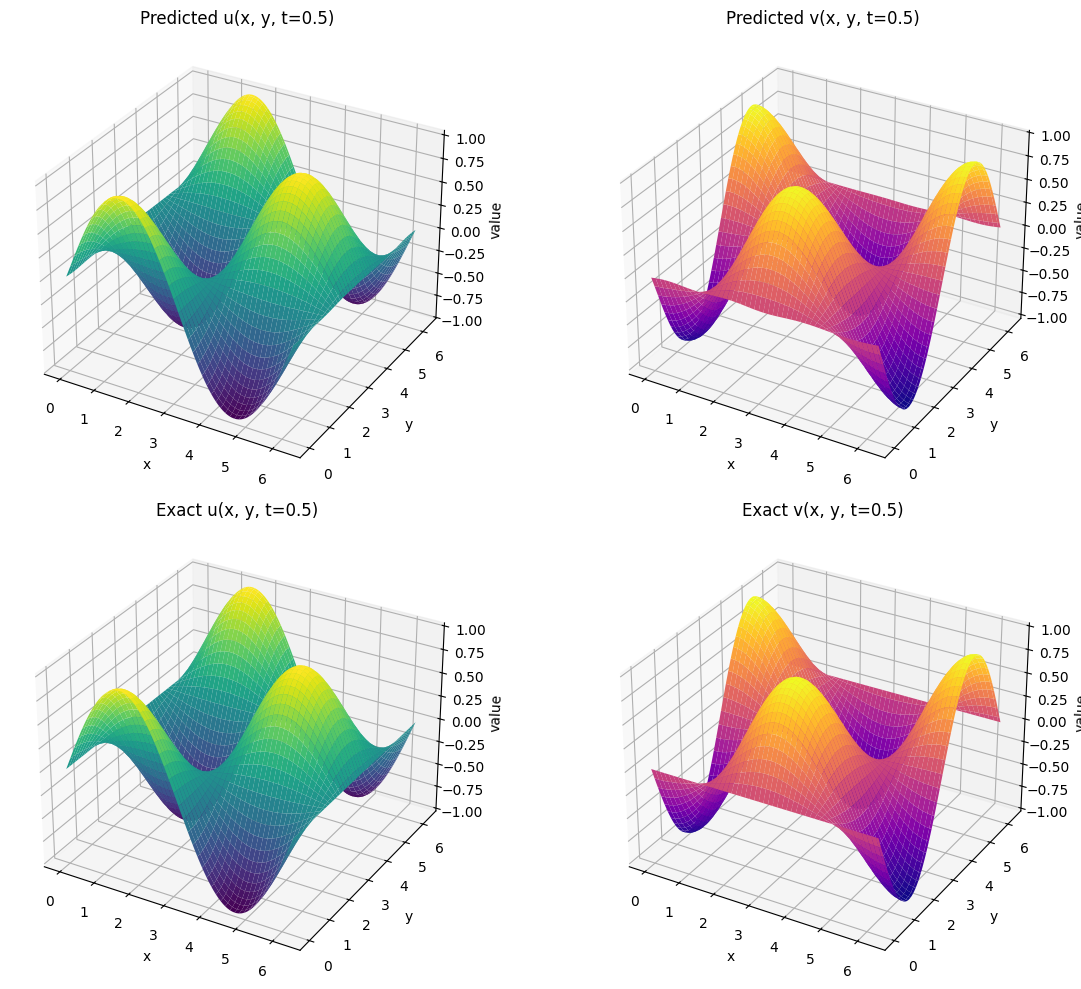

In [ ]:
# defining the training step. It is a lot more efficient to do it as a @tf.function.
@tf.function
def train_step():
  with tf.GradientTape() as tape:
    uvp_i_p = model(xyt_i)
    uvp_bl_p = model(xyt_bl)
    uvp_br_p = model(xyt_br)

    loss_i = tf.reduce_mean(tf.square(uvp_i - uvp_i_p))

    loss_b = tf.reduce_mean(tf.square(uvp_bl_p[:,0:2] - uvp_br_p[:,0:2]))


    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x_p,y_p,t_p])
      with tf.GradientTape(persistent=True) as tape3:
        tape3.watch([x_p,y_p,t_p])
        with tf.GradientTape(persistent=True) as tape4:
          tape4.watch([x_p,y_p,t_p])

          xyt_p = tf.concat([x_p,y_p,t_p],axis=1)
          uvp_p = model(xyt_p)

          u_p = uvp_p[:,0]

          du = tape4.gradient(u_p,xyt_p)
          u_x = du[:,0]
          u_y = du[:,1]
          u_t = du[:,2]

          u_xx = tape4.gradient(u_x,xyt_p)[:,0]
          u_yy = tape4.gradient(u_y,xyt_p)[:,1]

          del tape4

        v_p = uvp_p[:,1]

        dv = tape3.gradient(v_p,xyt_p)
        v_x = dv[:,0]
        v_y = dv[:,1]
        v_t = dv[:,2]

        v_xx = tape3.gradient(v_x,xyt_p)[:,0]
        v_yy = tape3.gradient(v_y,xyt_p)[:,1]

        del tape3

      p_p = uvp_p[:,2]

      dp = tape2.gradient(p_p,xyt_p)
      p_x = dp[:,0]
      p_y = dp[:,1]

      del tape2

    loss_m1 = tf.reduce_mean(tf.square(u_t + u_p*u_x + v_p*u_y + p_x - mu*(u_xx + u_yy)))
    loss_m2 = tf.reduce_mean(tf.square(v_t + u_p*v_x + v_p*v_y + p_y - mu*(v_xx + v_yy)))
    loss_c = tf.reduce_mean(tf.square(u_x + v_y))

    loss_p = loss_m1 + loss_m2 + loss_c

    loss = loss_i + loss_b + loss_p

  gradients = tape.gradient(loss,model.trainable_variables)
  optimizer.apply_gradients(zip(gradients,model.trainable_variables))

  return loss

epochs = 20001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


for epoch in range(epochs):
  loss = train_step()

  if epoch % 5000 == 0:
    print(f"Epoch {epoch}, Loss: {loss.numpy()}")

    # plotting
    uvp_pred = model(xyt_tensor).numpy()
    u_pred = uvp_pred[:, 0].reshape(N_p, N_p)
    v_pred = uvp_pred[:, 1].reshape(N_p, N_p)
    p_pred = uvp_pred[:, 2].reshape(N_p, N_p)

    u = u_exact(xyt_tensor[:,0],xyt_tensor[:,1],xyt_tensor[:,2]).numpy().reshape(N_p, N_p)
    v = v_exact(xyt_tensor[:,0],xyt_tensor[:,1],xyt_tensor[:,2]).numpy().reshape(N_p, N_p)
    p = p_exact(xyt_tensor[:,0],xyt_tensor[:,1],xyt_tensor[:,2]).numpy().reshape(N_p, N_p)

    fig = plt.figure(figsize=(18, 10))

    # Predicted
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    ax1.plot_surface(X, Y, u_pred, cmap='viridis')
    ax1.set_title("Predicted u(x, y, t=0.5)")

    ax2 = fig.add_subplot(2, 3, 2, projection='3d')
    ax2.plot_surface(X, Y, v_pred, cmap='plasma')
    ax2.set_title("Predicted v(x, y, t=0.5)")


    # Exact
    ax3 = fig.add_subplot(2, 3, 4, projection='3d')
    ax3.plot_surface(X, Y, u, cmap='viridis')
    ax3.set_title("Exact u(x, y, t=0.5)")

    ax4 = fig.add_subplot(2, 3, 5, projection='3d')
    ax4.plot_surface(X, Y, v, cmap='plasma')
    ax4.set_title("Exact v(x, y, t=0.5)")


    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("value")

    plt.tight_layout()
    plt.show()

As we can see, after 20000 epochs, the model genelarizes and predicts quite well the for the values of v and u. Lets find its accuracy using some test data points.

In [ ]:
x_test = tf.random.uniform((50,1),minval=0.0,maxval=2*pi,dtype=tf.float32)
y_test = tf.random.uniform((50,1),minval=0.0,maxval=2*pi,dtype=tf.float32)
t_test = tf.random.uniform((50,1),minval=0.0,maxval=1.0,dtype=tf.float32)
xyt_test = tf.concat([x_test,y_test,t_test],axis=1)
uv_test = model(xyt_test)[:,0:2]
uv_exact = tf.concat([u_exact(x_test,y_test,t_test),v_exact(x_test,y_test,t_test)],axis=1)

error_u = tf.reduce_mean(tf.square(uv_test[:,0] - uv_exact[:,0]))
error_v = tf.reduce_mean(tf.square(uv_test[:,1] - uv_exact[:,1]))
print(f"Error in u: {error_u}")
print(f"Error in v: {error_v}")

Error in u: 0.0004302410816308111
Error in v: 0.0002625183842610568


As we can see, the errors in both u and v are of the order of magnitude of 1e-4, which is considered quite good for any type of PINN.

The reason we are not focusing on p(x,y,t) is that the conditions defined in the problem setup are not enough for the model to learn the known exact solution of p as it did for u and v. We can formulate the laplace equation for pressure using the three differential equations and that can be used to model another PINN which solves only for p using the already predicted results for u and v.